In [117]:
#load all needed modules
import pandas as pd
import numpy as np
import requests
import json
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

In [3]:
#Set Pandas display options to no limits
pd.set_option('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', None)

# Gathering Data

## Getting Twitter Archive data from local file

In [4]:
# Create df for tweets
ta_df = pd.read_csv('twitter-archive-enhanced.csv')

In [5]:
ta_df.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
48,882992080364220416,NaN,NaN,2017-07-06 15:58:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Rusty. He wasn't ready for the first pic. Clearly puppared for the second. 13/10 confirmed great boy https://t.co/tyER0KpdXj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/882992080364220416/photo/1,https://twitter.com/dog_rates/status/882992080364220416/photo/1",13,10,Rusty,None,None,None,None
2001,672482722825261057,NaN,NaN,2015-12-03 18:29:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is light saber pup. Ready to fight off evil with light saber. 10/10 true hero https://t.co/LPPa3btIIt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672482722825261057/photo/1,10,10,light,None,None,None,None
701,786051337297522688,7.727430e+17,7.305050e+17,2016-10-12 03:50:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",13/10 for breakdancing puppo @shibbnbot,NaN,NaN,NaN,NaN,13,10,None,None,None,None,puppo


In [6]:
ta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## Getting Image Prediction info from file through URL

In [7]:
#download image predictions file from url
image_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(image_predictions_url)
with open ("image_predictions.tsv",mode='wb') as file:
        file.write(r.content)

In [8]:
#create image predictions df from downloaded file
ip_df = pd.read_csv("image_predictions.tsv", sep='\t')

In [9]:
ip_df.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2014,879415818425184262,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,1,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True
723,686007916130873345,https://pbs.twimg.com/media/CYUwjz-UAAEcdi8.jpg,1,Rhodesian_ridgeback,0.885301,True,redbone,0.042335,True,seat_belt,0.010493,False
519,676496375194980353,https://pbs.twimg.com/media/CWNl3S9WcAARN34.jpg,1,pug,0.985387,True,Norwegian_elkhound,0.004417,True,French_bulldog,0.003893,True


In [10]:
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## Getting Tweet Data from Twitter API 

#### Setting API Keys and Tokens

In [37]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''


In [38]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


In [39]:
tweet_ids = ta_df.tweet_id.values
len(tweet_ids)

2097

In [40]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888078434458587136
Success
21: 887705289381826560
Success
22: 887517139158093824
Success
23: 887473957103951883
Success
24: 887343217045368832
Success
25: 887101392804085760
Success
26: 886983233522544640
Success
27: 886736880519319552
Success
28: 886680336477933568
Success
29: 886366144734445568
Success
30: 886258384151887873
Success
31: 885984800019947520
Success
32: 885528943205470208
Success
33: 8855189715287

Success
261: 832998151111966721
Success
262: 832757312314028032
Success
263: 832682457690300417
Success
264: 832645525019123713
Success
265: 832636094638288896
Success
266: 832397543355072512
Success
267: 832369877331693569
Success
268: 832273440279240704
Success
269: 832032802820481025
Success
270: 831939777352105988
Success
271: 831911600680497154
Success
272: 831670449226514432
Success
273: 831650051525054464
Success
274: 831552930092285952
Success
275: 831322785565769729
Success
276: 831315979191906304
Success
277: 831309418084069378
Success
278: 831262627380748289
Success
279: 830956169170665475
Success
280: 830583320585068544
Success
281: 830097400375152640
Success
282: 829861396166877184
Success
283: 829501995190984704
Success
284: 829449946868879360
Success
285: 829374341691346946
Fail
286: 829141528400556032
Success
287: 829011960981237760
Success
288: 828770345708580865
Success
289: 828708714936930305
Success
290: 828650029636317184
Success
291: 828409743546925057
Success
292

Success
518: 788908386943430656
Success
519: 788765914992902144
Success
520: 788412144018661376
Success
521: 788178268662984705
Success
522: 788150585577050112
Success
523: 788039637453406209
Success
524: 787810552592695296
Success
525: 787717603741622272
Success
526: 787397959788929025
Success
527: 787322443945877504
Success
528: 786963064373534720
Success
529: 786709082849828864
Success
530: 786664955043049472
Success
531: 786595970293370880
Success
532: 786363235746385920
Success
533: 786286427768250368
Success
534: 786233965241827333
Success
535: 785927819176054784
Success
536: 785872687017132033
Success
537: 785639753186217984
Success
538: 785533386513321988
Success
539: 785515384317313025
Success
540: 785264754247995392
Success
541: 785170936622350336
Success
542: 784826020293709826
Success
543: 784517518371221505
Success
544: 784431430411685888
Success
545: 784183165795655680
Success
546: 784057939640352768
Success
547: 783839966405230592
Success
548: 783821107061198850
Success


Success
775: 749395845976588288
Success
776: 749317047558017024
Success
777: 749075273010798592
Success
778: 749064354620928000
Success
779: 749036806121881602
Success
780: 748977405889503236
Success
781: 748932637671223296
Success
782: 748705597323898880
Success
783: 748699167502000129
Success
784: 748692773788876800
Success
785: 748575535303884801
Success
786: 748568946752774144
Success
787: 748346686624440324
Success
788: 748337862848962560
Success
789: 748324050481647620
Success
790: 748307329658011649
Success
791: 748220828303695873
Success
792: 747963614829678593
Success
793: 747933425676525569
Success
794: 747885874273214464
Success
795: 747844099428986880
Success
796: 747816857231626240
Success
797: 747648653817413632
Success
798: 747600769478692864
Success
799: 747594051852075008
Success
800: 747512671126323200
Success
801: 747461612269887489
Success
802: 747439450712596480
Success
803: 747219827526344708
Success
804: 747204161125646336
Success
805: 747103485104099331
Success


Success
1031: 711363825979756544
Success
1032: 711306686208872448
Success
1033: 711008018775851008
Success
1034: 710997087345876993
Success
1035: 710844581445812225
Success
1036: 710833117892898816
Success
1037: 710658690886586372
Success
1038: 710609963652087808
Success
1039: 710588934686908417
Success
1040: 710296729921429505
Success
1041: 710283270106132480
Success
1042: 710272297844797440
Success
1043: 710269109699739648
Success
1044: 710153181850935296
Success
1045: 710140971284037632
Success
1046: 710117014656950272
Success
1047: 709918798883774466
Success
1048: 709901256215666688
Success
1049: 709852847387627521
Success
1050: 709566166965075968
Success
1051: 709556954897764353
Success
1052: 709519240576036864
Success
1053: 709449600415961088
Success
1054: 709409458133323776
Success
1055: 709225125749587968
Success
1056: 709207347839836162
Success
1057: 709198395643068416
Success
1058: 709179584944730112
Success
1059: 709158332880297985
Success
1060: 709042156699303936
Success
10

Success
1280: 691459709405118465
Success
1281: 691444869282295808
Success
1282: 691416866452082688
Success
1283: 691321916024623104
Success
1284: 691096613310316544
Success
1285: 691090071332753408
Success
1286: 690989312272396288
Success
1287: 690959652130045952
Success
1288: 690938899477221376
Success
1289: 690932576555528194
Success
1290: 690735892932222976
Success
1291: 690728923253055490
Success
1292: 690690673629138944
Success
1293: 690649993829576704
Success
1294: 690597161306841088
Success
1295: 690400367696297985
Success
1296: 690374419777196032
Success
1297: 690360449368465409
Success
1298: 690348396616552449
Success
1299: 690248561355657216
Success
1300: 690021994562220032
Success
1301: 690015576308211712
Success
1302: 690005060500217858
Success
1303: 689999384604450816
Success
1304: 689993469801164801
Success
1305: 689977555533848577
Success
1306: 689905486972461056
Success
1307: 689877686181715968
Success
1308: 689835978131935233
Success
1309: 689661964914655233
Success
13

Success
1529: 678399652199309312
Success
1530: 678396796259975168
Success
1531: 678389028614488064
Success
1532: 678380236862578688
Success
1533: 678341075375947776
Success
1534: 678334497360859136
Success
1535: 678278586130948096
Success
1536: 678255464182861824
Success
1537: 678021115718029313
Success
1538: 677961670166224897
Success
1539: 677918531514703872
Success
1540: 677895101218201600
Success
1541: 677716515794329600
Success
1542: 677700003327029250
Success
1543: 677698403548192770
Success
1544: 677687604918272002
Success
1545: 677673981332312066
Success
1546: 677662372920729601
Success
1547: 677644091929329666
Success
1548: 677573743309385728
Success
1549: 677565715327688705
Success
1550: 677557565589463040
Success
1551: 677547928504967168
Success
1552: 677530072887205888
Success
1553: 677335745548390400
Success
1554: 677334615166730240
Success
1555: 677331501395156992
Success
1556: 677328882937298944
Success
1557: 677314812125323265
Success
1558: 677301033169788928
Success
15

Success
1778: 671866342182637568
Success
1779: 671855973984772097
Success
1780: 671789708968640512
Success
1781: 671768281401958400
Success
1782: 671763349865160704
Success
1783: 671744970634719232
Success
1784: 671743150407421952
Success
1785: 671735591348891648
Success
1786: 671561002136281088
Success
1787: 671547767500775424
Success
1788: 671544874165002241
Success
1789: 671542985629241344
Success
1790: 671538301157904385
Success
1791: 671536543010570240
Success
1792: 671533943490011136
Success
1793: 671528761649688577
Success
1794: 671520732782923777
Success
1795: 671518598289059840
Success
1796: 671511350426865664
Success
1797: 671504605491109889
Success
1798: 671497587707535361
Success
1799: 671488513339211776
Success
1800: 671486386088865792
Success
1801: 671485057807351808
Fail
1802: 671390180817915904
Success
1803: 671362598324076544
Success
1804: 671357843010908160
Success
1805: 671355857343524864
Success
1806: 671347597085433856
Success
1807: 671186162933985280
Success
1808:

Success
2027: 667192066997374976
Success
2028: 667188689915760640
Success
2029: 667182792070062081
Success
2030: 667177989038297088
Success
2031: 667176164155375616
Success
2032: 667174963120574464
Success
2033: 667171260800061440
Success
2034: 667165590075940865
Success
2035: 667160273090932737
Success
2036: 667152164079423490
Success
2037: 667138269671505920
Success
2038: 667119796878725120
Success
2039: 667090893657276420
Success
2040: 667073648344346624
Success
2041: 667065535570550784
Success
2042: 667062181243039745
Success
2043: 667044094246576128
Success
2044: 667012601033924608
Success
2045: 666996132027977728
Success
2046: 666983947667116034
Success
2047: 666837028449972224
Success
2048: 666835007768551424
Success
2049: 666826780179869698
Success
2050: 666817836334096384
Success
2051: 666804364988780544
Success
2052: 666786068205871104
Success
2053: 666781792255496192
Success
2054: 666776908487630848
Success
2055: 666739327293083650
Success
2056: 666701168228331520
Success
20

In [11]:
#Read tweet_json file and convert to dictionary
list_of_jsons = []
td_df = pd.DataFrame(columns=['tweet_id','tweet_url','full_text', 'tweet_retweet_count','tweet_favorite_count','tweet_source','retweeted_status','language'])
with open('tweet_json.txt','r') as f:
    for line in f:
        jsondict = json.loads(line)
        if "retweeted_status" in jsondict:
            retweeted = "True"
        else:
            retweeted = "False"
        if jsondict["in_reply_to_status_id_str"] is None:
            is_reply = "False"
        else:
            is_reply = "True"
        
        if jsondict["truncated"] is True:
            is_truncated = "True"
        else:
            is_truncated = "False"
        
        my_jsondict = {'tweet_id':jsondict["id_str"],
                       'tweet_url': jsondict["full_text"][jsondict["full_text"].find('https://t.co'):],
                       'full_text':jsondict["full_text"][:jsondict["full_text"].find('https://t.co')], 
                       'tweet_retweet_count':jsondict["retweet_count"],
                       'tweet_favorite_count':jsondict["favorite_count"],
                       'tweet_source':jsondict['source'][jsondict["source"].find('>')+1:jsondict["source"].find("</a>")],
                       'retweeted_status': retweeted,
                       'reply_status' : is_reply,
                       'truncated' : is_truncated,
                       'language': jsondict["lang"]
                      }
        td_df = td_df.append(my_jsondict, ignore_index=True)

In [124]:
td_df.sample(3)

,tweet_id,tweet_url,full_text,tweet_retweet_count,tweet_favorite_count,tweet_source,user_id,user_followers_count,user_statuses_count,retweeted_status,language,reply_status,truncated
1880,669993076832759809,https://t.co/kR1fqy4NKK,This is Zoey. Her dreams of becoming a hippo ballerina don't look promising. 9/10 it'll be ok puppers,75,302,Twitter for iPhone,4196983835,8941057,13279,False,en,False,False
1445,681523177663676416,https://t.co/GQn2IopLud,This is Carly. She's actually 2 dogs fused together. Very innovative. Probably has superpowers. 12/10 for double dog,5519,13785,Twitter for iPhone,4196983835,8941053,13279,False,en,False,False
1718,672995267319328768,https://t.co/odpuqtz2Fq,This is Pumpkin. He can look in two different directions at once. Great with a screwdriver. 8/10,269,885,Twitter for iPhone,4196983835,8941056,13279,False,en,False,False


In [12]:
td_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tweet_id              2089 non-null   object
 1   tweet_url             2089 non-null   object
 2   full_text             2089 non-null   object
 3   tweet_retweet_count   2089 non-null   object
 4   tweet_favorite_count  2089 non-null   object
 5   tweet_source          2089 non-null   object
 6   retweeted_status      2089 non-null   object
 7   language              2089 non-null   object
 8   reply_status          2089 non-null   object
 9   truncated             2089 non-null   object
dtypes: object(10)
memory usage: 163.3+ KB


In [13]:
td_df.to_csv('twitter_api_data.csv', index = False)

Now we have 3 dataframes
1. ta_df 'Twitter Archive DataFrame' => this one containes data from the local file "twitter-archive-enhanced.csv"
2. ip_df 'Image Prediction DataFrame' => this one contains data of file "image_predictions.tsv" downloaded from the internet
3. td_df 'Twitter Data DataFrame' => this one contains data fetched through the Twitter API based on tweets id from ta_df

# Assessing Data

## Checking for Retweets

In [14]:
#Checking retweets in twitter data df
td_df.query('retweeted_status == "True"').shape[0]

0

In [15]:
#Checking retweets in twitter archive df
ta_df.query('retweeted_status_id == retweeted_status_id').shape[0]

181

## Checking for replies

In [16]:
#Checking replies in twitter data df
td_df.query('reply_status == "True"').shape[0]

0

In [17]:
#Checking replies in twitter archive df
ta_df.query('in_reply_to_status_id == in_reply_to_status_id').shape[0]

78

## Checking no-dog predictions

In [18]:
ip_df.query('(p1_dog == False) & (p2_dog == False) & (p3_dog == False)').shape[0]

324

## Checking wrong rating scale

In [19]:
ta_df.query('rating_denominator != 10').shape[0]

23

## Checking tweets with videos instead of photos

In [20]:
td_df[td_df['tweet_source'].str.contains("Vine")].shape[0]

91

## Checking number of tweets with dog stage

In [21]:
ta_df.query('(doggo == "doggo") | (floofer == "floofer") | (pupper == "pupper") | (puppo == "puppo")').shape[0]

380

## Checking tweets with missing dog names

In [22]:
len(ta_df[ta_df['name'].str.islower()].axes[0])+len(ta_df[ta_df['name'].str.contains('None')].axes[0])+len(ta_df[ta_df['name'].str.len()==1].axes[0])


910

# Cleaning Data

Data Quality Issues observed
1. Some tweets are retweets and not originals ('retweeted_status' == True 
and/or there's a value for in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp

2. Some tweets are replies (reply_status == True)

3. Some tweets do not have images or do not exist anymore (values in "fails_dict")

4. Some image prediciton doesn't have any dog breed in the result (p1_dog & p2_dog & p3_dog are all False)

5. Some tweets do not have the correct dog rating ta_df.query('rating_denominator != 10')

6. Some tweets have vine videos instead of photos (td_df['tweet_source'] == "Vine - Make a Scene")

7. Only a small fraction of tweets contain dog stage (less than 400 tweets) so this data is incomplete

8. Some entries have a wrong dog name (all entries under name starting with a small letter are wrong, other entries starting with capital letters are mostly correct)

## Deleting Retweets (Dirty Data No.1)

In [23]:
print("ta_df before: {}, ip_df before: {}, td_df before: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df = ta_df.query('retweeted_status_id != retweeted_status_id')
td_df = td_df.query('retweeted_status != "True"')

print("ta_df after: {}, ip_df after: {}, td_df after: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df before: (2356, 17), ip_df before: (2075, 12), td_df before: (2089, 10)
ta_df after: (2175, 17), ip_df after: (2075, 12), td_df after: (2089, 10)


## Deleting Replies (Dirty Data No.2)

In [24]:
print("ta_df before: {}, ip_df before: {}, td_df before: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

#Deleting replies in twitter data df
td_df = td_df.query('reply_status != "True"')
#Deleting replies in twitter archive df
ta_df = ta_df.query('in_reply_to_status_id != in_reply_to_status_id')

print("ta_df after: {}, ip_df after: {}, td_df after: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df before: (2175, 17), ip_df before: (2075, 12), td_df before: (2089, 10)
ta_df after: (2097, 17), ip_df after: (2075, 12), td_df after: (2089, 10)


## Deleting non-existing or no-image tweets (Dirty Data No.3)

In [ ]:
fails_dict.keys()

In [142]:
print("ta_df before: {}, ip_df before: {}, td_df before: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

for key in fails_dict.keys():
    ta_df = ta_df[ta_df.tweet_id != key]
    ip_df = ip_df[ip_df.tweet_id != key]
    td_df = td_df[td_df.tweet_id != key]
    
print("ta_df after: {}, ip_df after: {}, td_df after: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df before: (2097, 17), ip_df before: (2075, 12), td_df before: (2089, 13)
ta_df after: (2089, 17), ip_df after: (2067, 12), td_df after: (2089, 13)


## Deleting tweets with no-dog predictions (Dirty Data No.4)

In [26]:
print("ta_df before: {}, ip_df before: {}, td_df before: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ip_df = ip_df.query('(p1_dog == True) | (p2_dog == True) | (p3_dog == True)')

print("ta_df after: {}, ip_df after: {}, td_df after: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df before: (2097, 17), ip_df before: (2075, 12), td_df before: (2089, 10)
ta_df after: (2097, 17), ip_df after: (1751, 12), td_df after: (2089, 10)


## Deleting tweets with wrong rating scale (Dirty Data No.5)

In [27]:
print("ta_df before: {}, ip_df before: {}, td_df before: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df = ta_df.query('rating_denominator == 10')

print("ta_df after: {}, ip_df after: {}, td_df after: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df before: (2097, 17), ip_df before: (1751, 12), td_df before: (2089, 10)
ta_df after: (2080, 17), ip_df after: (1751, 12), td_df after: (2089, 10)


## Deleting tweets with vine videos instead of photos (Dirty Data No.6)

In [28]:
print("ta_df before: {}, ip_df before: {}, td_df before: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df = ta_df[ta_df['source'].str.contains("Vine") == False]
td_df = td_df[td_df['tweet_source'].str.contains("Vine") == False]

print("ta_df after: {}, ip_df after: {}, td_df after: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df before: (2080, 17), ip_df before: (1751, 12), td_df before: (2089, 10)
ta_df after: (1989, 17), ip_df after: (1751, 12), td_df after: (1998, 10)


## Deleting dog stage columns (Dirty Data No.7)

In [29]:
print("ta_df before: {}, ip_df before: {}, td_df before: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df.drop(['doggo' , 'floofer','pupper','puppo'] , axis='columns',inplace = True)

print("ta_df after: {}, ip_df after: {}, td_df after: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df before: (1989, 17), ip_df before: (1751, 12), td_df before: (1998, 10)
ta_df after: (1989, 13), ip_df after: (1751, 12), td_df after: (1998, 10)


## Deleting tweets with no valid dog names (Dirty Data No.8)

In [30]:
print("ta_df before: {}, ip_df before: {}, td_df before: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df = ta_df[ta_df['name'].str.istitle()]
ta_df = ta_df.query('name != "None"')
ta_df = ta_df[ta_df['name'].str.len() != 1]

print("ta_df after: {}, ip_df after: {}, td_df after: {}".format(ta_df.shape,ip_df.shape,td_df.shape))

ta_df before: (1989, 13), ip_df before: (1751, 12), td_df before: (1998, 10)
ta_df after: (1339, 13), ip_df after: (1751, 12), td_df after: (1998, 10)


Data Tidiness Issues observed

1. Some columns have the wrong data type
2. Tables are separated
3. Some columns are redundant
4. Some columns are not well named

## Converting tweet_id to string (Untidy Data No.1)

In [31]:
ta_df["tweet_id"] = ta_df["tweet_id"].astype(str)
ip_df["tweet_id"] = ip_df["tweet_id"].astype(str)
td_df["tweet_id"] = td_df["tweet_id"].astype(str)

## Converting timestamp to datetime (Untidy Data No.1)

In [32]:
ta_df["timestamp"]= pd.to_datetime(ta_df["timestamp"])

## Converting counts to numeric (Untidy Data No.1)

In [33]:
td_df[["tweet_retweet_count", "tweet_favorite_count"]] = td_df[["tweet_retweet_count", "tweet_favorite_count"]].apply(pd.to_numeric)

In [34]:
## Merging tables (Untidy Data No.2)

In [35]:
merged_df = pd.merge(left=ta_df, right=ip_df, left_on='tweet_id', right_on='tweet_id')

In [36]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 0 to 1176
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1177 non-null   object             
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1177 non-null   datetime64[ns, UTC]
 4   source                      1177 non-null   object             
 5   text                        1177 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1177 non-null   object             
 10  rating_numerator            1177 non-null   int64           

In [82]:
comb_df = pd.merge(left=merged_df, right=td_df, left_on='tweet_id', right_on='tweet_id')

In [83]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1168
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1169 non-null   object             
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1169 non-null   datetime64[ns, UTC]
 4   source                      1169 non-null   object             
 5   text                        1169 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1169 non-null   object             
 10  rating_numerator            1169 non-null   int64           

In [84]:
comb_df.sample(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_url,full_text,tweet_retweet_count,tweet_favorite_count,tweet_source,retweeted_status,language,reply_status,truncated
921,677530072887205888,NaN,NaN,2015-12-17 16:45:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Axel. He's a Black Chevy Pinot on wheels. 0 to 60 in 5.7 seconds (if downhill). 9/10 I call shotgun https://t.co/DKe9DBnnHE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677530072887205888/photo/1,9,10,Axel,https://pbs.twimg.com/media/CWcSAI-WUAAOB9W.jpg,1,Staffordshire_bullterrier,0.689259,True,Norwegian_elkhound,0.026121,True,American_Staffordshire_terrier,0.023075,True,https://t.co/DKe9DBnnHE,Say hello to Axel. He's a Black Chevy Pinot on wheels. 0 to 60 in 5.7 seconds (if downhill). 9/10 I call shotgun,217,1021,Twitter for iPhone,False,en,False,False


## Dropping redundant columns (Untidy Data No.3)

In [85]:
comb_df.drop(['in_reply_to_status_id','in_reply_to_user_id','source','text','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls','rating_denominator','img_num','retweeted_status','reply_status','truncated'], axis=1, inplace=True)

In [86]:
comb_df.sample(1)

,tweet_id,timestamp,rating_numerator,name,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_url,full_text,tweet_retweet_count,tweet_favorite_count,tweet_source,language
1038,671115716440031232,2015-11-29 23:57:10+00:00,6,Phred,https://pbs.twimg.com/media/CVBILUgVAAA1ZUr.jpg,malinois,0.406341,True,kelpie,0.143366,True,dingo,0.129802,False,https://t.co/mZD7Bo7HfV,"Meet Phred. He isn't steering, looking at the road, or wearing a seatbelt. Phred is a rolling tornado of danger 6/10",719,1273,Twitter for iPhone,en


In [87]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1168
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   tweet_id              1169 non-null   object             
 1   timestamp             1169 non-null   datetime64[ns, UTC]
 2   rating_numerator      1169 non-null   int64              
 3   name                  1169 non-null   object             
 4   jpg_url               1169 non-null   object             
 5   p1                    1169 non-null   object             
 6   p1_conf               1169 non-null   float64            
 7   p1_dog                1169 non-null   bool               
 8   p2                    1169 non-null   object             
 9   p2_conf               1169 non-null   float64            
 10  p2_dog                1169 non-null   bool               
 11  p3                    1169 non-null   object             
 12  p3_con

## Properly renaming columns (Untidy Data No.4)

In [88]:
comb_df.rename(columns = {'name':'dog_name','full_text':'tweet_text','p1':'p1_breed','p2':'p2_breed','p3':'p3_breed','p1_conf':'p1_confidence','p2_conf':'p2_confidence','p3_conf':'p3_confidence','p1_dog':'p1_is_dog','p2_dog':'p2_is_dog','p3_is_dog':'p3_dog'}, inplace = True) 

In [89]:
comb_df.to_csv('clean_twitter_data.csv', index = False)

In [45]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1168
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   tweet_id              1169 non-null   object             
 1   timestamp             1169 non-null   datetime64[ns, UTC]
 2   rating_numerator      1169 non-null   int64              
 3   dog_name              1169 non-null   object             
 4   jpg_url               1169 non-null   object             
 5   p1_breed              1169 non-null   object             
 6   p1_confidence         1169 non-null   float64            
 7   p1_is_dog             1169 non-null   bool               
 8   p2_breed              1169 non-null   object             
 9   p2_confidence         1169 non-null   float64            
 10  p2_is_dog             1169 non-null   bool               
 11  p3_breed              1169 non-null   object             
 12  p3_con

# Analyzing and Visualizing Data

In [97]:
most_common_name = comb_df['dog_name'].mode()[0]
count_most_common_name = comb_df.query('dog_name == @most_common_name').shape[0]
print("The most common dog name we have is {} with {} occurences".format(most_common_name,count_most_common_name))

The most common dog name in the tweets we have is Cooper with 10 occurences


In [161]:
most_retweets = comb_df['tweet_retweet_count'].max()
most_favorites = comb_df['tweet_favorite_count'].max()
most_retweeted = comb_df.loc[comb_df['tweet_retweet_count'] == most_retweets, 'tweet_url'].iloc[0]
most_favorited = comb_df.loc[comb_df['tweet_favorite_count'] == most_favorites, 'tweet_url'].iloc[0]
most_retweeted_dog_rate = comb_df.loc[comb_df['tweet_retweet_count'] == most_retweets, 'rating_numerator'].iloc[0]
most_retweeted_dog_name = comb_df.loc[comb_df['tweet_retweet_count'] == most_retweets, 'dog_name'].iloc[0]
most_favorited_dog_name = comb_df.loc[comb_df['tweet_favorite_count'] == most_favorites, 'dog_name'].iloc[0]
most_favorited_dog_rate = comb_df.loc[comb_df['tweet_favorite_count'] == most_favorites, 'dog_name'].iloc[0]

print("The most tweeted tweet for WeRateDogs is {} it was retweeted {} times it rates {} with {}/10".format(most_retweeted,most_retweets,most_retweeted_dog_name,most_retweeted_dog_rate))
print("The most favorited tweet for WeRateDogs is {} it was favorited {} times it rates {} with {}/10".format(most_favorited,most_favorites,most_favorited_dog_name,most_favorited_dog_rate))

The most tweeted tweet for WeRateDogs is https://t.co/DkBYaCAg2d it was retweeted 54647 times it rates Stephan with 13/10
The most favorited tweet for WeRateDogs is https://t.co/DkBYaCAg2d it was favorited 116922 times it rates Stephan with Stephan/10


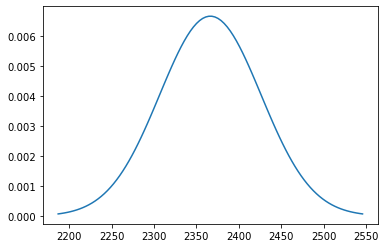

In [162]:
tweet_ret_mean = comb_df.tweet_retweet_count.describe()[1]
tweet_ret_variance = comb_df.tweet_retweet_count.describe()[2]
sigma = math.sqrt(tweet_ret_variance)
x = np.linspace(tweet_ret_mean - 3*sigma, tweet_ret_mean + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, tweet_ret_mean, sigma))
plt.show()

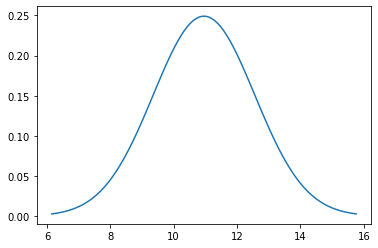

In [119]:
rate_num_mean = comb_df.rating_numerator.describe()[1]
rate_num_variance = comb_df.rating_numerator.describe()[2]
sigma = math.sqrt(rate_num_variance)
x = np.linspace(rate_num_mean - 3*sigma, rate_num_mean + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, rate_num_mean, sigma))
plt.show()

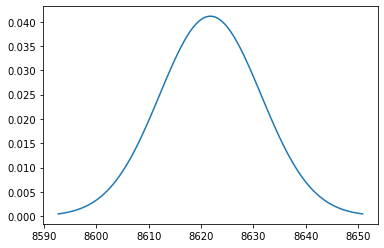

In [123]:
tweet_fav_mean = comb_df.tweet_favorite_count.describe()[1]
tweet_fav_variance = comb_df.tweet_favorite_count.describe()[2]
sigma = math.sqrt(tweet_fav_variance)
x = np.linspace(tweet_fav_mean - 3*sigma, tweet_fav_mean + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, tweet_fav_mean, sigma))
plt.show()

In [127]:
comb_df.describe()

,rating_numerator,p1_confidence,p2_confidence,p3_confidence,tweet_retweet_count,tweet_favorite_count
count,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000
mean,10.954662,0.609763,0.135098,0.061223,2366.377246,8621.769033
std,2.565344,0.270838,0.100948,0.052508,3577.228798,11104.697831
min,2.000000,0.044333,0.000014,0.000003,18.000000,94.000000
25%,10.000000,0.375313,0.052695,0.014897,614.000000,2153.000000
50%,11.000000,0.610499,0.120853,0.049148,1380.000000,4617.000000
75%,12.000000,0.873233,0.198361,0.095197,2850.000000,11136.000000
max,75.000000,0.999962,0.467678,0.271042,54647.000000,116922.000000


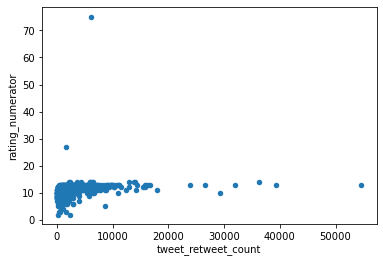

In [168]:
comb_df.plot(x='tweet_retweet_count', y='rating_numerator',kind='scatter');